# COMP3314 - Assignment 2

## Question 2: Spam classifier (20 Points)

In [1]:
import string
import warnings
warnings.filterwarnings("ignore")

### Step 1: Download dataset
Download examples of spam and ham from Apache SpamAssassin’s public datasets. Split the datasets into a training set and a test set. 

In [1]:
import os
import numpy as np
import glob
from urllib.request import urlretrieve
import tarfile
import shutil
import sklearn.utils
from sklearn.model_selection import train_test_split


def download_dataset():

    def download_url(url, dataset_dir="data"):

        tar_dir = os.path.join(dataset_dir, "tar")
        if not os.path.isdir(tar_dir):
            os.makedirs(tar_dir)

        filename = url.rsplit("/", 1)[-1]
        tarpath = os.path.join(tar_dir, filename)

        try:
            tarfile.open(tarpath)
        except:
            urlretrieve(url, tarpath)

        with tarfile.open(tarpath) as tar:
            dirname = os.path.join(dataset_dir, tar.getnames()[0])
            if os.path.isdir(dirname):
                shutil.rmtree(dirname)
            tar.extractall(path=dataset_dir)

            cmds_path = os.path.join(dirname, "cmds")
            if os.path.isfile(cmds_path):
                os.remove(cmds_path)

        return dirname

    def load_dataset(dirpath):
        files = []
        filepaths = glob.glob(dirpath + "/*")
        for path in filepaths:
            with open(path, "rb") as f:
                byte_content = f.read()
                str_content = byte_content.decode("utf-8", errors="ignore")
                files.append(str_content)
        return files

    spam_url = "https://spamassassin.apache.org/old/publiccorpus/20050311_spam_2.tar.bz2"
    easy_ham_url = "https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham_2.tar.bz2"
    hard_ham_dir = "https://spamassassin.apache.org/old/publiccorpus/20030228_hard_ham.tar.bz2"

    spam = load_dataset(download_url(spam_url))
    easy_ham = load_dataset(download_url(easy_ham_url))
    hard_ham = load_dataset(download_url(hard_ham_dir))

    X = spam + easy_ham + hard_ham
    y = np.concatenate((
        np.ones(len(spam)),
        np.zeros(len(easy_ham) + len(hard_ham)),
    ))

    return X, y


# Download dataset.
X, y = download_dataset()

# Split dataset into training and testing sets.
X, y = sklearn.utils.shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

print(f"The number of training samples: {len(X_train)}")
print(f"The number of test samples: {len(X_test)}")

The number of training samples: 2436
The number of test samples: 610


### Step 2: Feature extraction (5 points)

Next, we are going to do some data cleaning and feature extraction.

1. Some data cleaning functions have been provided to you. You'll need to implement `lower_letters()`, `convert_num_to_word()`, and `remove_punctuation()`. These functions will convert email to lowercase, replace all numbers with "NUM", and remove punctuation.
2. Convert each email into a feature vector. Your preparation pipeline should transform an email into a (sparse) vector that indicates the presence or absence of each possible word. For example, if all emails only ever contain four words, "Hello," "how," "are," "you," then the email "Hello you Hello Hello you" would be converted into a vector [1, 0, 0, 1] (meaning ["Hello" is present, "how" is absent, "are" is absent, "you" is present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of each word. You may check sklearn's `CountVectorizer` class for reference.

In [2]:
import re
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline


class EmailCleaner(BaseEstimator, TransformerMixin):

    def __init__(self,
                 no_header=True,
                 to_lowercase=True,
                 url_to_word=True,
                 num_to_word=True,
                 remove_punc=True):
        self.no_header = no_header
        self.to_lowercase = to_lowercase
        self.url_to_word = url_to_word
        self.num_to_word = num_to_word
        self.remove_punc = remove_punc

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_cleaned = []
        for email in X:
            if self.no_header:
                email = EmailCleaner.remove_header(email)
            if self.to_lowercase:
                email = EmailCleaner.lower_letters(email)

            email_words = email.split()
            if self.url_to_word:
                email_words = EmailCleaner.convert_url_to_word(email_words)
            if self.num_to_word:
                email_words = EmailCleaner.convert_num_to_word(email_words)
            email = " ".join(email_words)
            if self.remove_punc:
                email = EmailCleaner.remove_punctuation(email)
            X_cleaned.append(email)
        return X_cleaned

    @staticmethod
    def remove_header(email):
        return email[email.index("\n\n"):]

    @staticmethod
    def is_url(s):
        url = re.match(
            "http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|"
            "[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", s)
        return url is not None

    @staticmethod
    def convert_url_to_word(words):
        for i, word in enumerate(words):
            if EmailCleaner.is_url(word):
                words[i] = "URL"
        return words

    @staticmethod
    def lower_letters(email):
        # === Your code here ===
        return email.lower()
        # ======================

    @staticmethod
    def convert_num_to_word(words):
        # === Your code here ===
        words_copy = []
        for word in words:
            if word.isdecimal():
                words_copy.append("NUM")
            else:
                words_copy.append(word)
        return words_copy
        # ======================

    @staticmethod
    def remove_punctuation(email):
        # === Your code here ===
        return re.sub(r'[^\w\s]', '', email)

        # ======================

In [3]:
# Here are some unit tests to check your code.
# Your code should at least pass the following tests.
# Feel free to add more tests if you"d like.

# Check lower_letters().
src_string = "Message-Id: <LISTMANAGERSQL-25343"
dst_string = "message-id: <listmanagersql-25343"
assert EmailCleaner.lower_letters(src_string) == dst_string

# Check convert_num_to_word().
src_string = "Date: Wed, 10 Jul 2002"
src_words = src_string.split()
dst_words = ["Date:", "Wed,", "NUM", "Jul", "NUM"]
assert EmailCleaner.convert_num_to_word(src_words) == dst_words

# Check remove_punctuation().
src_string = "superstars -- you'll find investing more fun..."
dst_string = "superstars  youll find investing more fun"
assert EmailCleaner.remove_punctuation(src_string) == dst_string

In [4]:
# Step 1 of pipeline: data cleaning.
email_cleaner = EmailCleaner()

# Step 2 of pipeline: CountVectorizer.
# === Your code here ===
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()
# ======================

# Build pipeline.
prepare_pipeline = Pipeline([
    ("email_cleaner", email_cleaner),
    ("count_vectorizer", count_vectorizer),
])

# Run preprocessing.
X_all = X_train + X_test
prepare_pipeline.fit(X_all)
X_all = prepare_pipeline.transform(X_all)
num_train = len(X_train)
X_train = X_all[:num_train]
X_test = X_all[num_train:]

print(X_train.shape)
print(X_test.shape)

(2436, 109042)
(610, 109042)


### Step 3: Train a spam classifier (5 points)

Next, let's build a spam classifier, and train your classifier with the training set.

In [6]:
# === Your code here ===
from sklearn.linear_model import SGDClassifier
clf1 = SGDClassifier(alpha=0.1, tol=1e-3,max_iter=100,penalty='l2', random_state = 1, loss='hinge', class_weight='balanced')
clf1.fit(X_train, y_train)
# ======================

SGDClassifier(alpha=0.1, class_weight='balanced', max_iter=100, random_state=1)

### Step 4: Eval your classifier

Test your classifier with the test set and print the precision and recall.

In [7]:
# === Your code here ===
from sklearn.metrics import recall_score, precision_score
y_pred = clf1.predict(X_test)
print(clf1)
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
# ======================

SGDClassifier(alpha=0.1, class_weight='balanced', max_iter=100, random_state=1)
Recall: 0.971
Precision: 0.948


### Step 5: Ensemble of classifiers (5 points)

1. Implement 4 new classifiers (in total you have 5 claassifiers now).
2. Use hard or soft voting to ensemble thoses classifiers.
3. Train your ensemble model on the training set. Report training/testing precision and recall.

In [13]:
# === Your code here ===
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
clf2 = LogisticRegression(C=0.001, tol=1e-3,solver='saga',max_iter=100,penalty='l2', class_weight='balanced')
clf3 = DecisionTreeClassifier(criterion="gini",max_depth=20,random_state = 1, splitter = 'best',class_weight='balanced')
clf4 = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=5)
clf5 = SVC(kernel='rbf',class_weight='balanced')

clf = [clf1, clf2, clf3, clf4, clf5]

from sklearn.ensemble import VotingClassifier
estimators = []
for i, clf_ in enumerate(clf):
    estimators.append(('clf'+str(i), clf_))
eclf1 = VotingClassifier(estimators=estimators, n_jobs=4)
eclf1.fit(X_train, y_train)
y_pred = eclf1.predict(X_test)


all_clf = [clf1, clf2, clf3, clf4, clf5, eclf1]
clf_labels = ['SGD', "Logistic", "Tree", "kNN", "SVM", "Ensemble"]
recall = []
precision = []
for clf_ in all_clf:
    clf_.fit(X_train, y_train)
    y_pred = clf_.predict(X_test)
    recall.append(recall_score(y_true=y_test, y_pred=y_pred))
    precision.append(precision_score(y_true=y_test, y_pred=y_pred))    

for i in range(len(all_clf)):
    print(clf_labels[i])
    print('Recall: %.3f' % recall[i])
    print('Precision: %.3f' % precision[i])
    print('=====================')
# ======================

/Users/yimingzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yimingzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


SGD
Recall: 0.971
Precision: 0.948
Logistic
Recall: 0.936
Precision: 0.919
Tree
Recall: 0.946
Precision: 0.930
kNN
Recall: 0.943
Precision: 0.913
SVM
Recall: 0.889
Precision: 0.954
Ensemble
Recall: 0.964
Precision: 0.957


/Users/yimingzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


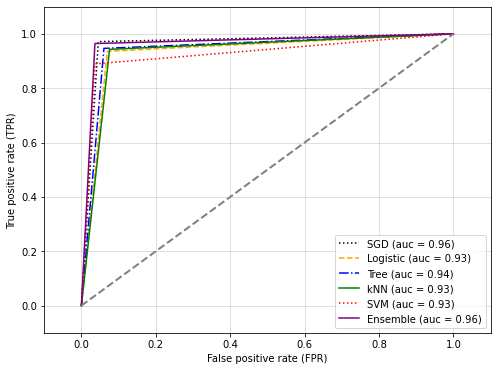

In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green', 'red', 'purple']
linestyles = [':', '--', '-.', '-', 'dotted', 'solid']
plt.figure(figsize=(8, 6))
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

Therefore, we can see Ensemble classifier outperforms most of other classifiers I used.